<a href="https://colab.research.google.com/github/megankaym/MLproject1/blob/main/ML_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Convolutional Neural Networks with PyTorch

Similar to traditional Neural Networks, Convolutional Neural Networks are built using neurons but instead of only fully connected layers, convolutional networks also have convolutional layers.

In general, convnets consist of two parts: a convolutional base and a fully connected classifier. The convolutional base automatically extract the features that are subsequently feed to a dense classifier, which outputs the probabilities of an image to belong to a certain class.


So let's start by importing some standard modules and the MNIST dataset module. 


In [1]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import statistics

PyTorch is installed in Colab by default, but it's always a good practice to check what version we'll be working with. 

In [2]:
print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)

PyTorch version: 1.13.0+cu116
Torchvision version: 0.14.0+cu116


## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size)
```

num_in_channels is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

num_out_channels is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

So for instance, if we have an RGB image and we are going to apply 32 filters of 3x3:



```
torch.nn.Conv2d(3, 32, 3)
```





## A Simple Convolutional Neural Network

In our convnet we'll use the next structure:

*input -> convolution -> pooling-> convolution -> pooling -> convolution* (convolutional base)

*fully connected -> fully connected -> output*


In [3]:
class BasicCNN(nn.Module):
    
    def __init__(self, num_channels, num_classes):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3*3*64, 64, bias=True)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, X):
        x = F.relu(self.conv1(X))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

**Convolution #1**

32 kernels of 3x3; *Width/Height:* (28 - 3 + 2x0) / 1 + 1 = 26; *Output dimensions:* (32, 26, 26)

**Max Pooling #1**

filter size = 2, stride = 2; *Width/Height:* (26 - 2) / 2 + 1 = 13; *Output dimensions:* (32, 13, 13)

**Convolution #2**

64 kernels of 3x3; *Width/Height:* (13 - 3 + 2x0) / 1 + 1 = 11; *Output dimensions:* (64, 11, 11)

**Max Pooling #2**

filter size = 2, stride = 2; *Width/Height:* (11 - 2) / 2 + 1 = 5; *Output dimensions:* (64, 5, 5)

**Convolution #3**

64 kernels of 3x3; *Width/Height:* (5 - 3 + 2x0) / 1 + 1 = 3; *Output dimensions:* (64, 3, 3)

So at the end of the last convolutional layer we get a tensor of dimension (64, 3, 3). And since now we are going to feed it to out fully connected classifier, we need to convert it into a vector, and for that we use the reshape method:



```
x = x.reshape(-1, 3*3*64)
```

## Starting Up Our Model

We'll send the model to our GPU so we need to create a CUDA device and instantiate our model:

In [4]:
cuda = torch.device('cuda')

model = BasicCNN(1, 10)
model.to(cuda)

BasicCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

## MNIST Datatset

In [5]:
dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

train_set = MNIST('./mnist', train=True, download=True, transform=dataset_transform)
valid_set  = MNIST('./mnist', train=False, download=True, transform=dataset_transform)


#check the size of our tensors
print(train_set.data.shape)
print(valid_set.data.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
train_loader = DataLoader(train_set, batch_size=128, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

We now create a dummy matrix x to simulate the input of a MNIST image, and check we get the right output in terms of dimensions:

In [7]:
# https://pytorch.org/docs/stable/nn.html#conv2d
# input: (N, C_in, H, W) -> N: batch, C_in: number of channels, H: height, W: width
x = torch.randn(128, 1, 28, 28, device=cuda)
output = model(x)
print(output.shape)

torch.Size([128, 10])


### Training the Model

**Optimizer: Stochastic Gradient Descent**




In [8]:
# https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
# Stochastic gradient descent optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

**Train function**

In [9]:
def train(model, loss_fn, optimizer):
    
    #set the module in training mode
    model.train()
    
    train_batch_losses = []
    
    for batch, labels in train_loader:
        
        #send the training data to the GPU
        batch = batch.to(cuda)
        labels = labels.to(cuda)
        
        #set all gradients to zero
        optimizer.zero_grad()
        
        #forward propagate
        y_pred = model(batch)
        
        #calculate the loss
        loss = loss_fn(y_pred, labels)
        
        #bachpropagate
        loss.backward()
        
        #update the parameters (weights and biases)
        optimizer.step()
        
        train_batch_losses.append(float(loss))
        
        mean_loss = statistics.mean(train_batch_losses)
        
    return mean_loss

**Validation function**

In [10]:
def validate(model, loss_fn, optimizer):
    
    # set the model in evaluation mode
    model.eval()
    
    # save predictions for later
    pedrictions = []
    
    # stop tracking the parameters for backpropagation
    with torch.no_grad():
        
        validation_batch_losses = []
        
        for batch, labels in valid_loader:
            
            # send the validation data to GPU
            batch = batch.to(cuda)
            labels = labels.to(cuda)
            
            # forward propagate
            labels_pred = model(batch)
            
            # calculate loss
            loss = loss_fn(labels_pred, labels)
            
            validation_batch_losses.append(float(loss))
            
            mean_loss = statistics.mean(validation_batch_losses)
           
    return mean_loss 

**Accuracy function**



In [11]:
def accuracy(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)
            
            labels_pred = model(batch)
            
            _, predicted = torch.max(labels_pred.data, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            return (100 * correct / total)

**Training Statistics function**

In [12]:
def training_stats(train_loss, train_accuracy, val_loss, val_accuracy):
    print(('training loss: {:.3f} '
           'training accuracy: {:.2f}% || '
           'val. loss: {:.3f} '
           'val. accuracy: {:.2f}%').format(train_loss, train_accuracy,
                                            val_loss, val_accuracy))

**Training our Convolutional Neural Network**

Now it's time to train our brand new convolutional neural network. We'll use the cross entropy function as our loss function (in pytorch softmax is included in the cross entropy function).

In [13]:
loss_fn = nn.CrossEntropyLoss()


train_acc = []
valid_acc = []

for epoch in range(1, 1+20):
    
    print('Epoch number', epoch)
    
    train_loss = train(model, loss_fn, optimizer)
    train_accuracy = accuracy(model, train_loader)
    train_acc.append(train_accuracy)
    
    valid_loss = validate(model, loss_fn, optimizer)
    valid_accuracy = accuracy(model, valid_loader)
    valid_acc.append(valid_accuracy)

    training_stats(train_loss, train_accuracy, valid_loss, valid_accuracy)

Epoch number 1
training loss: 0.283 training accuracy: 98.44% || val. loss: 0.067 val. accuracy: 96.88%
Epoch number 2
training loss: 0.066 training accuracy: 99.22% || val. loss: 0.053 val. accuracy: 98.24%
Epoch number 3
training loss: 0.048 training accuracy: 99.22% || val. loss: 0.054 val. accuracy: 98.24%
Epoch number 4
training loss: 0.037 training accuracy: 99.22% || val. loss: 0.055 val. accuracy: 98.63%
Epoch number 5
training loss: 0.033 training accuracy: 100.00% || val. loss: 0.039 val. accuracy: 99.02%
Epoch number 6
training loss: 0.031 training accuracy: 100.00% || val. loss: 0.047 val. accuracy: 98.24%
Epoch number 7
training loss: 0.023 training accuracy: 100.00% || val. loss: 0.047 val. accuracy: 99.02%
Epoch number 8
training loss: 0.023 training accuracy: 100.00% || val. loss: 0.044 val. accuracy: 98.24%
Epoch number 9
training loss: 0.022 training accuracy: 93.75% || val. loss: 0.064 val. accuracy: 98.05%
Epoch number 10
training loss: 0.023 training accuracy: 99.2

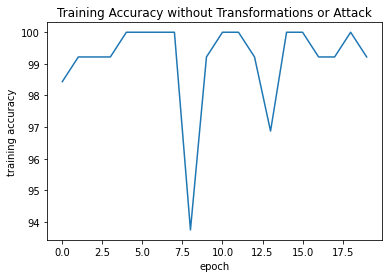

In [14]:
import matplotlib.pyplot as plt

x_axis_info = []
for i in range(len(train_acc)):
  x_axis_info.append(i)
x_axis = [x_axis_info]
y_axis = [train_acc]
x_list = [item for sublist in x_axis for item in sublist]
y_list = [item for sublist in y_axis for item in sublist]
plt.plot(x_list, y_list)
plt.title('Training Accuracy without Transformations or Attack')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# define the function of displaying multiple images
def show_images(images) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')
    
    plt.show(block=True)

# define the function of displaying multiple images
def show_images_withPred(images,label,pred,conf) -> None:
    n: int = images.size(0)
    
    f = plt.figure(figsize=(24, 6))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        plt.axis('off')
    
    plt.show(block=True)


# Hyperparameters and Data loaders
num_epochs = 10
num_classes = 10
batch_size = 256
learning_rate = 0.001


DATA_PATH = 'data/'
MODEL_STORE_PATH = 'models/'

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor()])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# CNN
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(1, -1),
        )
        self.fc1 = nn.Linear(7 * 7 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            
    def forward(self, x):
        out = self.features(x)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out


model=LeNet()
model.cuda()
model.train()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Model training
model.train()
loss_list = []
acc_list = []
total_step = len(train_loader)

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)

    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and percform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/10], Step [0/235], Loss: 2.3067, Accuracy: 9.77%
Epoch [1/10], Step [150/235], Loss: 0.1397, Accuracy: 96.48%
Epoch [2/10], Step [0/235], Loss: 0.1269, Accuracy: 95.31%
Epoch [2/10], Step [150/235], Loss: 0.0685, Accuracy: 97.66%
Epoch [3/10], Step [0/235], Loss: 0.0495, Accuracy: 98.83%
Epoch [3/10], Step [150/235], Loss: 0.0849, Accuracy: 96.48%
Epoch [4/10], Step [0/235], Loss: 0.0963, Accuracy: 97.27%
Epoch [4/10], Step [150/235], Loss: 0.0573, Accuracy: 98.05%
Epoch [5/10], Step [0/235], Loss: 0.0352, Accuracy: 99.61%
Epoch [5/10], Step [150/235], Loss: 0.0544, Accuracy: 97.66%
Epoch [6/10], Step [0/235], Loss: 0.0209, Accuracy: 99.61%
Epoch [6/10], Step [150/235], Loss: 0.0920, Accuracy: 97.66%
Epoch [7/10], Step [0/235], Loss: 0.0924, Accuracy: 97.66%
Epoch [7/10], Step [150/235], Loss: 0.0538, Accuracy: 99.22%
Epoch [8/10], Step [0/235], Loss: 0.0152, Accuracy: 99.61%
Epoch [8/10], Step [150/235], Loss: 0.0309, Accuracy: 98.83%
Epoch [9/10], Step [0/235], Loss: 0.0357,

In [16]:
# Model Evaluation
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Accuracy of the model on the 10000 test images: 97.72 %


Accuracy of the model on the 10000 test images: 14.75 %


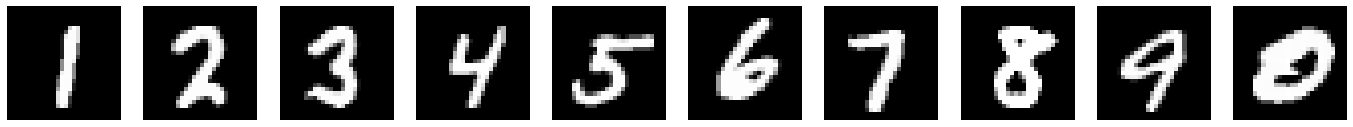

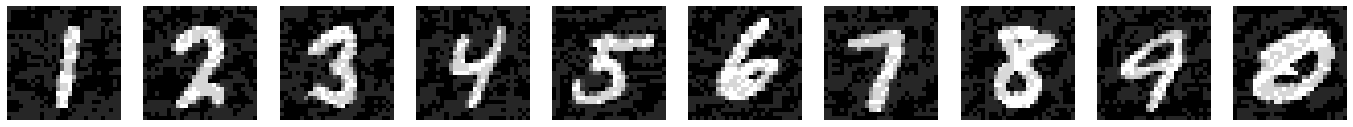

In [17]:
def ae_attack(model, criterion, images, labels, step_size) :
    
    images.requires_grad = True
            
    outputs = model(images) #feed the original images to the model, and get the predictions
    
    model.zero_grad() #zero out the gradients
    loss = criterion(outputs, labels) # compute loss value
    loss.backward() # feedback to the model, compute the gradients.

    ae_images = images + step_size*images.grad.sign()

    ae_images = torch.clamp(ae_images, 0, 1)
    
    return ae_images

model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = ae_attack(model, criterion, images, labels, step_size=0.15)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())

In [18]:
new_dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=5),
    transforms.Normalize([0.1307], [0.3081])
])

new_train_set = MNIST('./mnist', train=True, download=True, transform=new_dataset_transform)
new_valid_set  = MNIST('./mnist', train=False, download=True, transform=new_dataset_transform)


#check the size of our tensors
print(new_train_set.data.shape)
print(new_valid_set.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [19]:
new_train_loader = DataLoader(new_train_set, batch_size=128, num_workers=0, shuffle=True)
new_valid_loader = DataLoader(new_valid_set, batch_size=512, num_workers=0, shuffle=False)

In [20]:
new_loss_fn = nn.CrossEntropyLoss()

new_train_acc = []
new_valid_acc = []

for epoch in range(1, 1+20):
    
    print('Epoch number', epoch)
    
    new_train_loss = train(model, new_loss_fn, optimizer)
    new_train_accuracy = accuracy(model, new_train_loader)
    new_train_acc.append(new_train_accuracy)
    
    new_valid_loss = validate(model, new_loss_fn, optimizer)
    new_valid_accuracy = accuracy(model, new_valid_loader)
    new_valid_acc.append(new_valid_accuracy)

    training_stats(new_train_loss, new_train_accuracy, new_valid_loss, new_valid_accuracy)

Epoch number 1
training loss: 0.031 training accuracy: 89.84% || val. loss: 1.457 val. accuracy: 89.84%
Epoch number 2
training loss: 0.028 training accuracy: 92.97% || val. loss: 0.853 val. accuracy: 92.97%
Epoch number 3
training loss: 0.026 training accuracy: 89.84% || val. loss: 1.061 val. accuracy: 92.77%
Epoch number 4
training loss: 0.024 training accuracy: 85.94% || val. loss: 1.066 val. accuracy: 91.80%
Epoch number 5
training loss: 0.022 training accuracy: 88.28% || val. loss: 1.308 val. accuracy: 89.65%
Epoch number 6
training loss: 0.021 training accuracy: 89.84% || val. loss: 1.067 val. accuracy: 94.14%
Epoch number 7
training loss: 0.021 training accuracy: 84.38% || val. loss: 1.145 val. accuracy: 92.19%
Epoch number 8
training loss: 0.021 training accuracy: 96.88% || val. loss: 0.607 val. accuracy: 94.14%
Epoch number 9
training loss: 0.018 training accuracy: 94.53% || val. loss: 1.100 val. accuracy: 92.19%
Epoch number 10
training loss: 0.015 training accuracy: 90.62% |

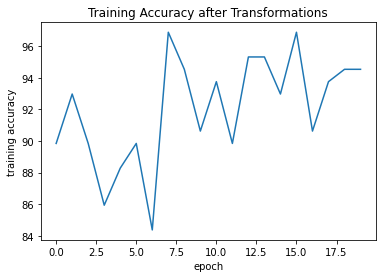

In [21]:
x_axis_info = []
for i in range(len(new_train_acc)):
  x_axis_info.append(i)
x_axis = [x_axis_info]
y_axis = [new_train_acc]
flat_x_list = [item for sublist in x_axis for item in sublist]
flat_y_list = [item for sublist in y_axis for item in sublist]
plt.plot(flat_x_list, flat_y_list)
plt.title('Training Accuracy after Transformations')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

Accuracy of the model on the 10000 test images: 25.8 %


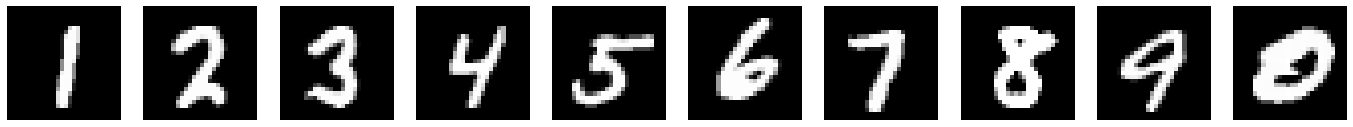

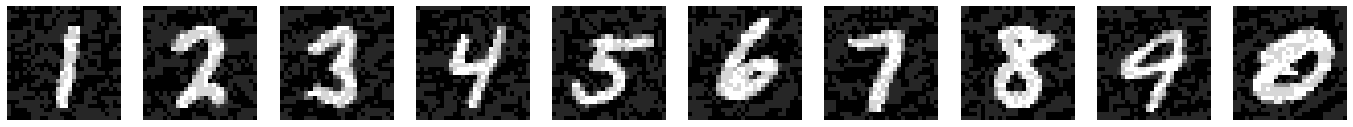

In [22]:
model.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    ae_images = ae_attack(model, criterion, images, labels, step_size=0.15)

    outputs = model(ae_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


show_images(images[:10].detach())
show_images(ae_images[:10].detach())